<a href="https://colab.research.google.com/github/rajagopalmotivate/DeepLearningforSocietal/blob/main/Copy_of_Copy_of_text_classification_with_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with Transformer

**Author:** [Apoorv Nandan](https://twitter.com/NandanApoorv)<br>
**Date created:** 2020/05/10<br>
**Last modified:** 2020/05/10<br>
**Description:** Implement a Transformer block as a Keras layer and use it for text classification.

## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Implement a Transformer block as a layer

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Download and prepare dataset

In [ ]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


## Create classifier model using transformer layer

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

## Train and Evaluate

In [ ]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Epoch 1/2
782/782 [==============================] - 87s 100ms/step - loss: 0.3839 - accuracy: 0.8196 - val_loss: 0.3085 - val_accuracy: 0.8655
Epoch 2/2
782/782 [==============================] - 24s 30ms/step - loss: 0.1977 - accuracy: 0.9256 - val_loss: 0.3064 - val_accuracy: 0.8746


In [ ]:
model.evaluate(x_val, y_val)

782/782 [==============================] - 4s 5ms/step - loss: 0.3064 - accuracy: 0.8746


[0.30638331174850464, 0.8746399879455566]

In [ ]:
model.predict(x_val[0:4])

1/1 [==============================] - 0s 194ms/step


array([[0.9576558 , 0.04234418],
       [0.00212748, 0.9978725 ],
       [0.10232998, 0.89767003],
       [0.6088715 , 0.39112848]], dtype=float32)

In [ ]:
import numpy as np

In [ ]:
np.argmax(model.predict(x_val[0:1]))

1/1 [==============================] - 0s 24ms/step


0

In [ ]:
y_val[0:1]

array([0])

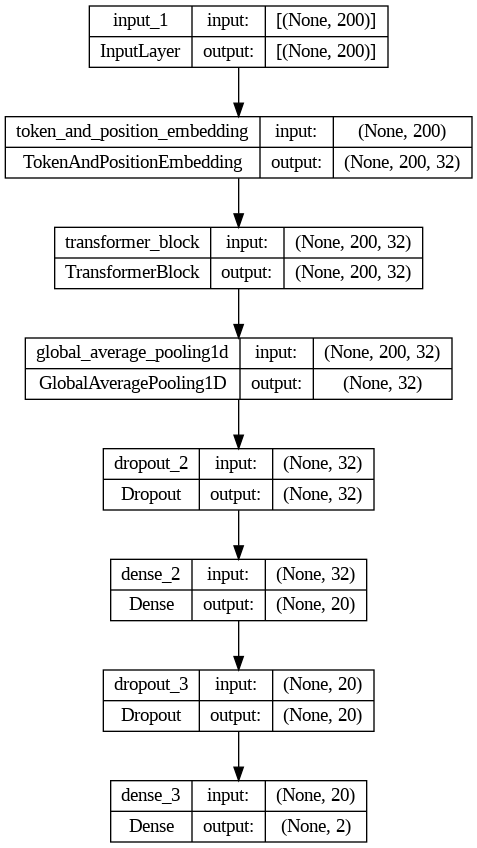

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)